# Symbolic Regression multi-objective. Scalar fitness function

#### 1. Libraries importation

In [1]:
import math
import random
import csv
import numpy
import operator
import matplotlib.pyplot as plt
from deap import algorithms, base, creator , tools, gp

#### 2. Defining primitive set

In [2]:
# Define new functions
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

#Second argument = number of variables in problem (this case, 'x')
pset = gp.PrimitiveSet("MAIN", 1)
#Second argument = arity
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
pset.addEphemeralConstant("rand101", lambda: random.randint(-10,10))
pset.renameArguments(ARG0='x')

#### 3. Parameters definition

In [3]:
creator.create("FitnessMin", base.Fitness, weights=(-1,-.01))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

def evalSymbReg(individual, points):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    # Evaluate the mean squared error between the expression
    # and the real function : x**4 + x**3 + x**2 + x
    #sqerrors = ((func(x) - x**4 - x**3 - x**2 - x )**2 for x in points)
    sqerrors = ((func(x) - (math.sin(x**2))**2 - math.sin(x) - (math.cos(x**2))**2 - math.cos(x) - x**3 - 2*x**2 - 4 )**2 for x in points)
    return math.fsum(sqerrors) / len(points)
def evaluate(individual, points): 
    return evalSymbReg(individual, points), individual.height 
    
toolbox.register("evaluate", evaluate, points=[x for x in range(-100,100)])
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

#### 4. Algorithm initialization

In [4]:
def main():
    random.seed(318)

    pop = toolbox.population(n=500)
    hof = tools.HallOfFame(1)

    # Ver que el fitness no es el MSE, es la combinacion de MSE y height
    stats_fit_mse = tools.Statistics(lambda ind: ind.fitness.values[0])
    stats_fit_height = tools.Statistics(lambda ind: ind.fitness.values[1])
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(mse=stats_fit_mse, height=stats_fit_height, size=stats_size)
    mstats.register("avg", numpy.mean)
    mstats.register("std", numpy.std)
    mstats.register("min", numpy.min)
    mstats.register("max", numpy.max)

    pop, log, hof = algorithms.eaSimpleOr(pop, toolbox, .8, .1, 250, stats=mstats,
                                   halloffame=hof, verbose=True)
    return pop, log, hof

if __name__ == "__main__":
    pop, log, hof = main()

Creating pandas dataframe


,mse_avg,mse_std,mse_min,mse_max,mse_gen,mse_nevals,height_avg,height_std,height_min,height_max,height_gen,height_nevals,size_avg,size_std,size_min,size_max,size_gen,size_nevals
0,1.427664e+11,1.215808e+08,1.415256e+11,1.442270e+11,1.0,457.0,1.606,0.650203,0.0,4.0,1.0,457.0,3.916,1.649528,1.0,10.0,1.0,457.0
1,1.427608e+11,1.853236e+08,1.423477e+11,1.445879e+11,2.0,458.0,1.642,0.754875,0.0,5.0,2.0,458.0,4.214,1.936028,1.0,15.0,2.0,458.0
2,1.427291e+11,1.546302e+08,1.415256e+11,1.436670e+11,3.0,462.0,1.618,0.819802,0.0,5.0,3.0,462.0,4.308,2.037924,1.0,15.0,3.0,462.0
3,1.427104e+11,2.710291e+08,1.408755e+11,1.456025e+11,4.0,440.0,1.696,0.896428,0.0,5.0,4.0,440.0,4.468,2.030019,1.0,12.0,4.0,440.0
4,1.427747e+11,1.405719e+09,1.403999e+11,1.680299e+11,5.0,448.0,1.856,0.931270,0.0,6.0,5.0,448.0,4.886,2.246109,1.0,17.0,5.0,448.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2.138068e+25,4.773839e+26,4.308667e-03,1.068533e+28,246.0,447.0,11.418,1.526852,3.0,17.0,246.0,447.0,121.150,26.743738,7.0,326.0,246.0,447.0
246,1.578955e+20,3.442030e+21,4.203480e-03,7.702307e+22,247.0,447.0,11.300,1.434573,3.0,17.0,247.0,447.0,118.532,23.355791,7.0,227.0,247.0,447.0
247,6.162949e+20,1.376451e+22,3.903800e-03,3.080922e+23,248.0,456.0,11.466,1.742654,1.0,17.0,248.0,456.0,119.974,25.928080,3.0,243.0,248.0,456.0
248,2.917221e+17,6.505151e+18,3.903800e-03,1.456057e+20,249.0,452.0,11.516,1.925031,3.0,17.0,249.0,452.0,116.406,26.310324,7.0,231.0,249.0,452.0


### 5. Simplifying resultant equation

In [5]:
from sympy import sympify

locals = {
    'sub': lambda x, y : x - y,
    'protectedDiv': lambda x, y : x/y,
    'mul': lambda x, y : x*y,
    'add': lambda x, y : x + y,
    'neg': lambda x    : -x,
    'pow': lambda x, y : x**y
}

ind = hof.__getitem__(0).__str__()
print(f'original: {ind}')
expr = sympify(str(ind) , locals=locals)
print(f'simplified: {expr}')


original: add(mul(mul(x, x), x), mul(add(add(protectedDiv(x, mul(x, x)), x), add(protectedDiv(x, mul(mul(3, mul(mul(x, x), x)), mul(mul(protectedDiv(add(x, x), x), mul(mul(mul(mul(sin(3), x), mul(x, x)), mul(x, neg(x))), x)), 9))), x)), add(protectedDiv(sin(add(cos(cos(-4)), x)), mul(x, protectedDiv(add(x, add(protectedDiv(x, neg(protectedDiv(add(x, add(protectedDiv(x, neg(4)), x)), x))), x)), x))), add(protectedDiv(mul(add(x, x), x), mul(mul(x, x), x)), add(protectedDiv(add(protectedDiv(x, mul(x, protectedDiv(-7, x))), add(x, add(mul(neg(-2), x), x))), mul(mul(x, mul(mul(mul(3, x), -2), x)), x)), x)))))
simplified: x**3 + (2*x + 1/x - 1/(54*x**8*sin(3)))*(x + 7*sin(x + cos(cos(4)))/(10*x) + 2/x - 9/(14*x**3))


### 6. Graphs

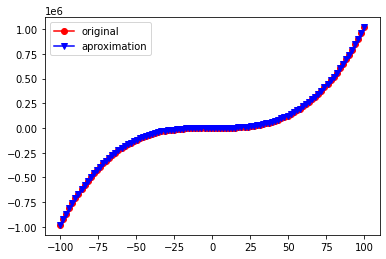

In [14]:
fig, ax = plt.subplots()
original = lambda x: (math.sin(x**2))**2 + math.sin(x) + (math.cos(x**2))**2 + math.cos(x) + x**3 + 2*x**2 + 4
ax.plot(numpy.linspace(-100,100,100), [original(x) for x in numpy.linspace(-100,100,100)], color = 'r', marker = 'o', label='original')
aprox = lambda x: toolbox.compile(hof.__getitem__(0))(x)
ax.plot(numpy.linspace(-100,100,100), [aprox(x) for x in numpy.linspace(-100,100,100)], color = 'b', marker='v', label='aproximation')
plt.legend()